In [2]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy.random import default_rng


import seaborn as sns
import numpy as np
import random
import logging
import time




import os
import re

from multiprocess import Pool

from tqdm import tqdm


In [3]:
# displaying options
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# deprecation warning set off
pd.options.mode.chained_assignment = None
np.set_printoptions(linewidth=np.inf)

In [3]:
logging.basicConfig(level=logging.INFO, filename='logs/NB_theory.log', format='%(asctime)s - %(levelname)s - %(message)s')


In [4]:
class SocialAgent(Agent):
    """Agent with personal network and state."""    
    def __init__(self, unique_id, model, n_nodes_int_belief, connected_agents, beta_values, beta_soc, rep, extNet, weight_ext):

        super().__init__(unique_id, model)
        
        self.unique_id = unique_id
        #self.runs = runs
        self.n_nodes = n_nodes_int_belief
        self.connected_agents = connected_agents
        self.beta_intPers = beta_values['intPers']
        self.beta_intSoc = beta_values['intSoc']
        self.beta_intSoc_dynamic = beta_soc
        self.beta_ext = beta_values['ext']
        self.extNet = extNet
        self.weight_ext = weight_ext
        self.fullConnNet = 0 #here, a full network will be stored
        self.pers_belief_network = self.create_belief_network(self.unique_id ,self.n_nodes, self.connected_agents, weight_int_pers = 0.4, weight_int_soc = 1.0)
        self.rep = rep
        
        

    def create_belief_network(self, unique_id, n_nodes, connected_agents, weight_int_pers, weight_int_soc):

        
        seed = os.getpid() + random.randint(1, 100)
        rng = default_rng(seed)

        G = nx.DiGraph()

        for i in range(n_nodes):
            if i == 0: 
                G.add_node(f'agent{unique_id}_focal_belief', value=rng.choice(np.linspace(-1, 1, 7))) 
            else:
                G.add_node(f'agent{unique_id}_belief_{i}', value=rng.choice(np.linspace(-1, 1, 7)))

        for c in connected_agents:
            G.add_node(f'agent{unique_id}_soc_belief_{c}', value=rng.choice(np.linspace(-1, 1, 7)))

            #print(f'agent{unique_id}_soc_belief_{c}')


        focal_node = f'agent{unique_id}_focal_belief'

        for i in range(1, n_nodes):
            G.add_edge(focal_node, f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
            G.add_edge(f'agent{unique_id}_belief_{i}', focal_node, weight=weight_int_pers)
            for j in range(1, n_nodes):
                if i != j:
                    G.add_edge(f'agent{unique_id}_belief_{j}', f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
                    G.add_edge(f'agent{unique_id}_belief_{i}', f'agent{unique_id}_belief_{j}', weight=weight_int_pers) 

        for c in connected_agents:
            G.add_edge(focal_node, f'agent{unique_id}_soc_belief_{c}', weight = weight_int_soc)
            G.add_edge(f'agent{unique_id}_soc_belief_{c}', focal_node, weight = weight_int_soc)


        return G
    

    

    def step(self):
        #print(connected_agents)
        self.create_full_connected_network(self.pers_belief_network, self.connected_agents)
        self.update_state()
        
    def get_value_dict(self):
        
        
        G = self.pers_belief_network
        beta_dict = self.beta_intSoc_dynamic
        
        upper_limit = self.beta_intSoc*2
        
    
        focal_node = list(G.nodes(data=True))[0][1]['value']

        soc_beliefs = {int(index.split('_')[3]): belief['value']  for index, belief in G.nodes(data=True) if 'soc_belief' in index}

        for key, value in soc_beliefs.items():

            diff = focal_node - value
            norm = self.get_y_value(diff)
            
            
            current_value = beta_dict[key][-1]
            increment = (norm - 1)  * current_value * (1 - current_value / upper_limit)
            current_value += increment
            current_value = min(current_value, upper_limit)
            
            beta_dict[key].append(current_value)

        self.beta_intSoc_dynamic = beta_dict
        

    def dynamic_betas(self, adj_matrix):
        
        G = self.pers_belief_network
        beta_dict = self.beta_intSoc_dynamic
        adj = adj_matrix
    
        soc_belief_coords = {int(belief.split('_')[3]): index for index, belief in enumerate(G.nodes()) if 'soc_belief' in belief}

        for key, value in soc_belief_coords.items():
            #print(key, value, beta_dict)
            adj[value][0] = beta_dict[key][-1]
            adj[0][value] = beta_dict[key][-1]


        return adj
    
    
    
    def scaled_logistic(self, x, L, k, x0, ymin, ymax):

        y = L / (1 + np.exp(-k * (x - x0)))
        # Scale y to be in the range [ymin, ymax]
        # Since x is a single value, scaling directly without min/max functions
        scaled_y = (ymax - ymin) * (y - 0) / (1 - 0) + ymin  # simplified scaling for single x
        # Invert y around the midpoint of ymin and ymax to start and end high
        return ymax + ymin - scaled_y

    

    def get_y_value(self, x):

        L = 1        # Max value of the unscaled logistic function
        k = 3      # Adjusted steepness of the curve, reduced for a wider transition
        x0 = 0.5       # Midpoint of the sigmoid, where the lowest point is expected
        ymin = 0.1   # Minimum y value in the desired output
        ymax = 1.5     
        
        y = self.scaled_logistic(x, L, k, x0, ymin, ymax)
        
        return y
    
    
    def create_full_connected_network(self, focal_network, connected_agents):
        

        soc_beliefs_networks = [(connected_agent.unique_id, connected_agent.pers_belief_network) for connected_agent in self.model.schedule.agents if connected_agent.unique_id in connected_agents]

        fullNet = focal_network.copy()

        for id, net in soc_beliefs_networks:


            fullNet = nx.compose(fullNet, net)
            fullNet.add_edge(f'agent{id}_focal_belief', f'agent{self.unique_id}_soc_belief_{id}', weight = self.weight_ext)
            fullNet.add_edge(f'agent{self.unique_id}_focal_belief', f'agent{id}_soc_belief_{self.unique_id}', weight = self.weight_ext)



        self.fullConnNet = fullNet





    def update_state(self):

        fullNet = self.fullConnNet
        pers_net_nodes = self.pers_belief_network.nodes()

        fullNet_adj = nx.adjacency_matrix(fullNet).toarray()
        fullNetSim = fullNet_adj.copy()
     
        fullNetSim = self.dynamic_betas(fullNetSim)
        
        fullNetSim[fullNet_adj == 0.4] = fullNet_adj[fullNet_adj == 0.4] * self.beta_intPers
        #fullNetSim[fullNet_adj == 1.0] = fullNet_adj[fullNet_adj == 1.0] * self.beta_intSoc
        fullNetSim[fullNet_adj == 1.4] = fullNet_adj[fullNet_adj == 1.4] * self.beta_ext
        
        self.get_value_dict()
        
        
        for index, node in enumerate(pers_net_nodes):

            probUnstPerValue = []
            for k in range(7):
                connections = np.delete(fullNetSim[index], index)

                currentState = fullNet.nodes[node]['value']
                flippedState = np.linspace(-1, 1, 7)[k]
                connectedStates = [data['value'] for _, data in fullNet.nodes(data=True)]
                connectedStates = np.delete(np.array(connectedStates), index)

                probUnstPerValue.append(1/(1+ np.exp((-np.sum(connections * flippedState * connectedStates) + np.sum(connections * currentState * connectedStates)))))

            probPerValue = [k / sum(probUnstPerValue) for k in probUnstPerValue]
            
            a = np.random.choice(np.linspace(-1, 1, 7), 1,  p=probPerValue)[0]
            ###########################BUG fullNet.nodes[f'agent{self.unique_id}_belief_0']['value'] = a
            fullNet.nodes[node]['value'] = a
            
        updated_pers__network = fullNet.subgraph(pers_net_nodes).copy()
        self.pers_belief_network = updated_pers__network
        
        

        
        
    def get_focal_node_states(self):
        
        focal_node = self.pers_belief_network.nodes()[f'agent{self.unique_id}_focal_belief']['value']

        return focal_node
    
    
    def get_mean_node_states(self):

        pattern = r'agent(\d+)_belief_(\d+)'
        
        nodes = [data['value'] for i, data in self.pers_belief_network.nodes(data=True) if re.match(pattern, i)]

        mean_node_states = (sum(nodes)/len(nodes))

        return mean_node_states
    
    def get_node_states(self):
        
        #nodes = [(i, data['value']) for i, data in self.pers_belief_network.nodes(data=True)]
        nodes = self.pers_belief_network
        
        return nodes
    
    def get_extNet(self):
        
        return self.extNet
    
    
    def get_dynamic_beta(self):

        soc_beliefs = {int(index.split('_')[3]): belief['value']  for index, belief in self.pers_belief_network.nodes(data=True) if 'soc_belief' in index}
        
        latest_beta = {key : (soc_beliefs[key], value[-1]) for key, value in self.beta_intSoc_dynamic.items()}
            
        return latest_beta
            
        
    
    def get_test(self):
        
        return self.test
   
        


In [5]:
class NetworkModel(Model):   
    
    def __init__(self, n_nodes_int_pers, n_nodes_soc, beta_variations, ext_net, rep):

        super().__init__()

        self.schedule = RandomActivation(self)
        self.n_nodes_soc = n_nodes_soc
        self.n_nodes_int_pers = n_nodes_int_pers
        self.beta_variations = beta_variations
        self.ext_net = ext_net
        self.rep = rep       
        


        beta_soc = {}

        # Initialize agents and assign to external network nodes
        for i, node in enumerate(self.ext_net.nodes()):
            connected_agents = list(self.ext_net.neighbors(i))
            beta = self.beta_variations
            #for c in connected_agents:
            #beta_soc = {c:[self.beta_variations['intSoc']] for c in connected_agents}
            beta_soc = {c:[1] for c in connected_agents}
            #network = create_belief_network(i, self.n_nodes_int_pers, connected_agents, weight_int_pers=0.4, weight_int_soc=1.0)
            agent = SocialAgent(i, self, self.n_nodes_int_pers, connected_agents, self.beta_variations, beta_soc, self.rep, self.ext_net, weight_ext=1.4)
            self.schedule.add(agent)

        self.datacollector = DataCollector(
            agent_reporters={"betaIntPers" : "beta_intPers"
                             , "betaIntSoc" : "beta_intSoc"
                             , "betaExt" : "beta_ext"
                             , "rep" : "rep"
                             , "focalNodeStates" : SocialAgent.get_focal_node_states
                             , "meanNodeStates" : SocialAgent.get_mean_node_states
                             , "NodeStates" : SocialAgent.get_node_states
                             , "extNet" : SocialAgent.get_extNet
                             , "dynamic_betas" : SocialAgent.get_dynamic_beta
                            })
            #model_reporters={"focalNodeStates" : self.get_focal_node_states,
            #                 "meanNodeStates" : self.get_mean_node_states}
                             
                

    def step(self):
        #if self.schedule.steps > 38:
        self.datacollector.collect(self)
        #print(self.schedule.steps)
            
        self.schedule.step()

    

In [7]:
def run_simulation(params):

    model = NetworkModel(params['n_nodes_int_pers'], params['n_nodes_soc'], params['beta_variations'], params['ext_net'], params['n_reps'])
    #while model.schedule.steps < params['n_steps']:
    for _ in range(params['n_steps']):
        model.step()

    # Extract and return simulation data
    agent_data = model.datacollector.get_agent_vars_dataframe()
    #model_data = model.datacollector.get_model_vars_dataframe()

    #data = pd.concat([agent_data, model_data], axis = 1)
    return agent_data





def define_param_list(n_reps, n_nodes_int_pers, n_nodes_soc, n_steps, beta_values):
    
    sizes = [n_nodes_soc // 2, n_nodes_soc // 2]
    p_matrix = [[0.4, 0.01], [0.01, 0.4]]
    ext_net = nx.stochastic_block_model(sizes, p_matrix)
    ext_net_adj = nx.adjacency_matrix(ext_net).toarray()
    #np.save(f"data/extNet{n_nodes_soc}_{n_steps}.npy", ext_net_adj)
        
    #with reps:
    params = [{'ext_net': ext_net,'n_nodes_int_pers' : n_nodes_int_pers, 'n_nodes_soc' : n_nodes_soc, 'n_steps' : n_steps, 'n_reps' : i, 'beta_variations' : {'intPers': p, 'intSoc': s, 'ext': e}} for i in range(n_reps) for p in beta_values for s in beta_values for e in beta_values]
    
    #without reps
    #params = [{'ext_net': ext_net,'n_nodes_int_pers' : n_nodes_int_pers, 'n_nodes_soc' : n_nodes_soc, 'n_steps' : n_steps, 'beta_variations' : {'intPers': p, 'intSoc': s, 'ext': e}} for p in beta_values for s in beta_values for e in beta_values]

    return params



def pool_simulation(n_cores, params):
    sim_results= []

    pool = Pool(n_cores)

    for result in tqdm(
        pool.imap_unordered(func=run_simulation, iterable=params),
        total=len(params)
        ):
            #result['durchgang'] = params['n_reps']
            sim_results.append(result)

        
    pool.close()

    return pd.concat(sim_results)

    

In [ ]:
sizes = [n_nodes_soc // 2, n_nodes_soc // 2]
p_matrix = [[0.4, 0.01], [0.01, 0.4]]
ext_net = nx.stochastic_block_model(sizes, p_matrix)
ext_net_adj = nx.adjacency_matrix(ext_net).toarray()

In [ ]:
sim_results = pool_simulation(80, define_param_list(n_reps = 20, n_nodes_int_pers=10, n_nodes_soc=100, n_steps=50, beta_values=[0.5, 2]))

  0%|                                                   | 0/160 [00:00<?, ?it/s]

In [292]:
def set_identifier(df_s):
    
    df_s = df_s.reset_index()
    df_s['identifier'] = df_s.apply(lambda x: f"{x['betaIntPers']}-{x['betaIntSoc']}-{x['betaExt']}-{x['rep']}", axis=1)

    # Step 2: Convert the identifier to a categorical type and assign codes
    df_s['id'] = df_s['identifier'].astype('category').cat.codes
    df_s = df_s.drop(columns = ['identifier'])
    df_s = df_s[['betaIntPers', 'betaIntSoc', 'betaExt', 'AgentID', 'Step', 'id', 'focalNodeStates', 'meanNodeStates', "NodeStates", "rep"]]#, "Test"]]
    #df_s = df_s.rename(columns = {'durchgang' : 'rep'})
    
    return df_s

In [293]:
sim = set_identifier(sim_a_results)

In [299]:
sim.to_csv("data/prod_static_50steps.csv")

In [12]:
#sim[sim.AgentID == 1]

In [38]:
#a[a.AgentID == 2].head(10)

In [44]:
def scaled_logistic(x, L, k, x0, ymin, ymax):

    y = L / (1 + np.exp(-k * (x - x0)))
    # Scale y to be in the range [ymin, ymax]
    # Since x is a single value, scaling directly without min/max functions
    scaled_y = (ymax - ymin) * (y - 0) / (1 - 0) + ymin  # simplified scaling for single x
    # Invert y around the midpoint of ymin and ymax to start and end high
    return ymax + ymin - scaled_y



def get_y_value( x):

    L = 1        # Max value of the unscaled logistic function
    k = 3        
    x0 = 1       
    ymin = 0.2   
    ymax = 1.5     

    y = scaled_logistic(x, L, k, x0, ymin, ymax)

    return y
    

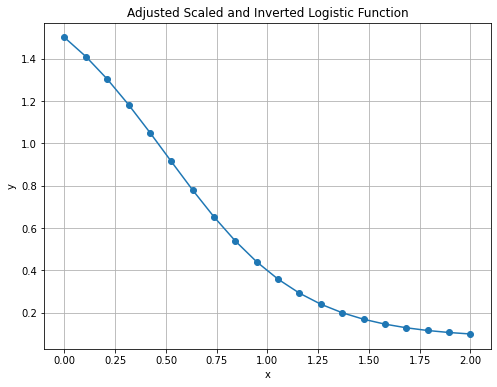

In [13]:
def scaled_logistic(x, L, k, x0, ymin, ymax):
    # Logistic function
    y = L / (1 + np.exp(-k * (x - x0)))
    # Scale y to be in the range [ymin, ymax]
    scaled_y = (y - np.min(y)) / (np.max(y) - np.min(y)) * (ymax - ymin) + ymin
    # Invert y around the midpoint of ymin and ymax to start and end high
    return ymax + ymin - scaled_y

# Create a sequence of x values from 0 to 2
x = np.linspace(0, 2, 20)

# Define parameters for the logistic function
L = 1        # Max value of the unscaled logistic function
k = 3      # Adjusted steepness of the curve, reduced for a wider transition
x0 = 0.5       # Midpoint of the sigmoid, where the lowest point is expected
ymin = 0.1   # Minimum y value in the desired output
ymax = 1.5     # Maximum y value in the desired output

# Calculate y values using the scaled logistic function
y = scaled_logistic(x, L, k, x0, ymin, ymax)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o')  # Line plot with points
plt.title("Adjusted Scaled and Inverted Logistic Function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

Final value: 3.992869193430423
All values: [2, 2.5, 2.96875, 3.3514404296875, 3.623141525313258, 3.7938179739137268, 3.8915951084717335, 3.94432860167246, 3.971776887762262, 3.9857888758730833, 3.992869193430423]


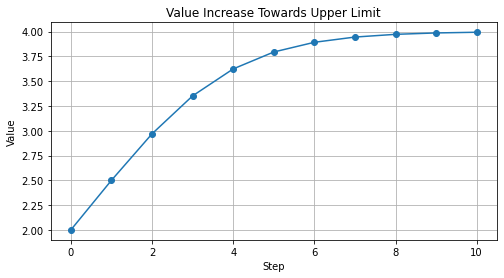

In [15]:
# Parameters
start_value = 2
upper_limit = 4
current_value = start_value
increment_factor = 1.5
values = [start_value]  # List to store the values for visualization

# Increment until the values are close to the upper limit
for _ in range(10):
    # Calculate the increment, reduced as currentValue approaches upperLimit
    increment = (increment_factor - 1) * current_value * (1 - current_value / upper_limit)
    current_value += increment
    current_value = min(current_value, upper_limit)  # Ensure it does not exceed upperLimit
    values.append(current_value)  # Store the value for visualization

# Print final result
print("Final value:", current_value)
print("All values:", values)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(values, marker='o', linestyle='-')
plt.title('Value Increase Towards Upper Limit')
plt.xlabel('Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [7]:
sim = sim_results.reset_index()

In [87]:
sim = sim[sim.Step == 1].copy()
sim.NodeStates[100]
adj = nx.adjacency_matrix(sim.NodeStates[103]).toarray()

In [153]:
g = sim[sim.AgentID == 0].extNet[0]

In [294]:
sim_a = sim[(sim.Step == 4) & (sim.betaIntPers == 2) & (sim.betaIntSoc == .5) & (sim.betaExt == .5) & (sim.rep == 3)]

In [295]:
sim_a.head(2)

,betaIntPers,betaIntSoc,betaExt,AgentID,Step,id,focalNodeStates,meanNodeStates,NodeStates,rep
350400,2.0000,0.5000,0.5000,0,4,93,1.0000,0.4074,"(agent0_soc_belief_47, agent0_belief_6, agent0_soc_belief_49, agent0_soc_belief_5, agent0_soc_belief_1, agent0_soc_belief_18, agent0_soc_belief_46, agent0_soc_belief_19, agent0_soc_belief_34, agent0_soc_belief_35, agent0_belief_1, agent0_belief_5, agent0_belief_8, agent0_soc_belief_14, agent0_belief_3, agent0_soc_belief_23, agent0_soc_belief_41, agent0_soc_belief_31, agent0_soc_belief_13, agent0_soc_belief_42, agent0_belief_9, agent0_soc_belief_33, agent0_soc_belief_3, agent0_soc_belief_2, agent0_belief_4, agent0_belief_2, agent0_soc_belief_29, agent0_soc_belief_37, agent0_soc_belief_7, agent0_soc_belief_30, agent0_belief_7, agent0_focal_belief)",3
350401,2.0000,0.5000,0.5000,1,4,93,-1.0000,-0.7778,"(agent1_soc_belief_15, agent1_soc_belief_17, agent1_soc_belief_30, agent1_soc_belief_42, agent1_soc_belief_32, agent1_soc_belief_40, agent1_soc_belief_25, agent1_soc_belief_27, agent1_soc_belief_51, agent1_belief_3, agent1_soc_belief_5, agent1_belief_2, agent1_soc_belief_9, agent1_soc_belief_49, agent1_belief_9, agent1_belief_6, agent1_soc_belief_24, agent1_belief_8, agent1_focal_belief, agent1_soc_belief_22, agent1_belief_4, agent1_soc_belief_4, agent1_soc_belief_0, agent1_belief_1, agent1_belief_7, agent1_soc_belief_13, agent1_belief_5, agent1_soc_belief_20, agent1_soc_belief_33)",3


In [296]:
df = pd.DataFrame(sim_a.groupby(["AgentID"])["focalNodeStates"].mean()).reset_index()

In [297]:
df.head(5)

,AgentID,focalNodeStates
0,0,1.0000
1,1,-1.0000
2,2,1.0000
3,3,-1.0000
4,4,1.0000


Graphic representation

In [ ]:
edges_in_graph = []
for index, row in sim_a.iterrows():
    d = row['dynamic_betas']
    #edges_per_agent = []
    for key, value in d.items():
        edges_in_graph.append((row.AgentID, key, value[1]))
    #edges_in_graph.append(edges_per_agent)
    

In [261]:
def get_color(value):
    # Define RGB for sea-blue and blood-red
    sea_blue = (39, 100, 123)  # RGB for #27647B
    blood_red = (202, 53, 66)  # RGB for #CA3542
    
    # Interpolate between sea-blue and blood-red based on value
    r = int(sea_blue[0] + (blood_red[0] - sea_blue[0]) * (value + 1) / 2)
    g = int(sea_blue[1] + (blood_red[1] - sea_blue[1]) * (value + 1) / 2)
    b = int(sea_blue[2] + (blood_red[2] - sea_blue[2]) * (value + 1) / 2)
    
    return f"#{r:02x}{g:02x}{b:02x}"

In [285]:
from pyvis.network import Network

net = Network(notebook=True, height="750px", width="100%")

# Add nodes with color defined by DataFrame
for index, row in df.iterrows():
    node_color = get_color(row['focalNodeStates'])
    if row['AgentID'] < 25:
        node_shape = 'square'
        node_size = 20
    else:
        node_shape = 'ellipse'
        node_size = 40
    net.add_node(int(row['AgentID']), color=node_color, shape = node_shape, size = node_size)

# Add edges from NetworkX graph
for start, end, weight in edges_in_graph:
    intensity = 255 - int(weight * 20)  # Calculate intensity, more weight => darker
    color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"  # Convert to hex
    net.add_edge(start, end, value=weight*0.001, color=color)

# Show the network
net.show("example.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Link updating mechanism


*Testing link update*

In [17]:
def create_belief_network(unique_id, n_nodes, connected_agents, weight_int_pers, weight_int_soc):

    seed = os.getpid() + unique_id
    #np.random.seed(seed)
    rng = default_rng(seed)

    G = nx.DiGraph()

    for i in range(n_nodes):
        if i == 0: 
            G.add_node(f'agent{unique_id}_focal_belief', value=rng.choice(np.linspace(-1, 1, 7))) 
        else:
            G.add_node(f'agent{unique_id}_belief_{i}', value=rng.choice(np.linspace(-1, 1, 7)))

    for c in connected_agents:
        G.add_node(f'agent{unique_id}_soc_belief_{c}', value=rng.choice(np.linspace(-1, 1, 7)))

        #print(f'agent{unique_id}_soc_belief_{c}')


    focal_node = f'agent{unique_id}_focal_belief'

    for i in range(1, n_nodes):
        G.add_edge(focal_node, f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
        G.add_edge(f'agent{unique_id}_belief_{i}', focal_node, weight=weight_int_pers)
        for j in range(1, n_nodes):
            if i != j:
                G.add_edge(f'agent{unique_id}_belief_{j}', f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
                G.add_edge(f'agent{unique_id}_belief_{i}', f'agent{unique_id}_belief_{j}', weight=weight_int_pers) 

    for c in connected_agents:
        G.add_edge(focal_node, f'agent{unique_id}_soc_belief_{c}', weight = weight_int_soc)
        G.add_edge(f'agent{unique_id}_soc_belief_{c}', focal_node, weight = weight_int_soc)


    return G

In [18]:
G = create_belief_network(1, 5, [2,4,7], 0.4, 1.0)

In [19]:
def create_full_connected_network(unique_id, focal_network, soc_belief_networks):


    fullNet = focal_network.copy()

    for id, net in soc_belief_networks:

        fullNet = nx.compose(fullNet, net)
        fullNet.add_edge(f'agent{id}_focal_belief', f'agent{unique_id}_soc_belief_{id}', weight = 1.4)
        fullNet.add_edge(f'agent{unique_id}_focal_belief', f'agent{id}_soc_belief_{unique_id}', weight = 1.4)


    return fullNet

In [20]:
G2 = create_belief_network(2, 5, [1,4,7], 0.4, 1.0)
G4 = create_belief_network(4, 5, [1,2,7], 0.4, 1.0)
G7 = create_belief_network(7, 5, [1,2,4], 0.4, 1.0)

In [21]:
soc_bel_nets = [(2,G2)]#, (4,G4), (7,G7)]

In [22]:
f_net = create_full_connected_network(1, G, soc_bel_nets)

In [23]:
fullNet = f_net
pers_net_nodes = G.nodes()

fullNet_adj = nx.adjacency_matrix(fullNet).toarray()
fullNetSim = fullNet_adj.copy()


#fullNetSim[fullNet_adj == 0.4] = fullNet_adj[fullNet_adj == 0.4] * self.beta_intPers
#fullNetSim[fullNet_adj == 1.0] = fullNet_adj[fullNet_adj == 1.0] * self.beta_intSoc
#fullNetSim[fullNet_adj == 1.4] = fullNet_adj[fullNet_adj == 1.4] * self.beta_ext


In [338]:
for index, node in enumerate(fullNet.nodes()) if 'soc_belief' in node
    if 'soc_belief' in node:
        print(index, node)

5 agent1_soc_belief_2
6 agent1_soc_belief_4
7 agent1_soc_belief_7
13 agent2_soc_belief_1
14 agent2_soc_belief_4
15 agent2_soc_belief_7


In [339]:
fullNet.nodes()

NodeView(('agent1_focal_belief', 'agent1_belief_1', 'agent1_belief_2', 'agent1_belief_3', 'agent1_belief_4', 'agent1_soc_belief_2', 'agent1_soc_belief_4', 'agent1_soc_belief_7', 'agent2_focal_belief', 'agent2_belief_1', 'agent2_belief_2', 'agent2_belief_3', 'agent2_belief_4', 'agent2_soc_belief_1', 'agent2_soc_belief_4', 'agent2_soc_belief_7'))

In [80]:
adj = nx.adjacency_matrix(fullNet).toarray()#

In [81]:
adj

array([[0. , 0.4, 0.4, 0.4, 0.4, 1. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 1.4, 0. , 0. ],
       [0.4, 0. , 0.4, 0.4, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.4, 0. , 0.4, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.4, 0.4, 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.4, 0.4, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1.4, 0. , 0. , 0. , 0.4, 0.4, 0.4, 0.4, 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0.4, 0.4, 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0.4, 0. , 0.4, 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0. 

In [130]:
beta_dict = {c:[1] for c in [2,4,7]}

In [118]:
def get_dynamic_weights(G, adj, beta_dict):
    
    soc_belief_coords = {int(belief.split('_')[3]): index for index, belief in enumerate(G.nodes()) if 'soc_belief' in belief}
    
    for key, value in soc_belief_coords.items():
        adj[value][0] = round(beta_dict[key][-1], 4)
        adj[0][value] = round(beta_dict[key][-1], 4)
        
        
    return adj

In [119]:
def get_value_dict(G, d):
        
    upper_limit = 2


    focal_node = list(G.nodes(data=True))[0][1]['value']

    soc_beliefs = {int(index.split('_')[3]): belief['value']  for index, belief in G.nodes(data=True) if 'soc_belief' in index}

    for key, value in soc_beliefs.items():

        diff = focal_node - value
        norm = get_y_value(diff)


        current_value = d[key][-1]
        increment = (norm - 1)  * current_value * (1 - current_value / upper_limit)
        current_value += increment
        current_value = min(current_value, upper_limit)

        d[key].append(current_value)

    return d

In [138]:
get_value_dict(G, beta_dict)

{2: [1,
  1.2191731824345815,
  1.4278179681508878,
  1.6068762744756606,
  1.745328234083037,
  1.8427476065619108,
  1.9062588380446364],
 4: [1,
  0.7748119238904968,
  0.5610430607232977,
  0.3792449424907034,
  0.24083012835544162,
  0.14542669897576316,
  0.08469246754301121],
 7: [1,
  0.6774818993143765,
  0.38851146232404804,
  0.18658875954096202,
  0.07746084032288576,
  0.029430961358578617,
  0.010726285049008962]}

In [139]:
get_dynamic_weights(G, adj, beta_dict)

array([[0.    , 0.4   , 0.4   , 0.4   , 0.4   , 1.9063, 0.0847, 0.0107, 0.    , 0.    , 0.    , 0.    , 0.    , 1.4   , 0.    , 0.    ],
       [0.4   , 0.    , 0.4   , 0.4   , 0.4   , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.4   , 0.4   , 0.    , 0.4   , 0.4   , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.4   , 0.4   , 0.4   , 0.    , 0.4   , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.4   , 0.4   , 0.4   , 0.4   , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [1.9063, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0847, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0107, 0.    , 0.    , 0.    , 0

In [ ]:
beta_dict

In [619]:
def get_dynamic_weights(G, adj):
    
    soc_belief_coords = {int(belief.split('_')[3]): index for index, belief in enumerate(G.nodes()) if 'soc_belief' in belief}
    
    for key, value in soc_belief_coords.items():
        adj[value][0] = beta_dict[key][-1]
        adj[0][value] = beta_dict[key][-1]
        
        
    return adj
    

In [594]:
soc_belief_coords = {int(belief.split('_')[3]): index for index, belief in enumerate(G.nodes()) if 'soc_belief' in belief}


In [611]:
for key, value in soc_belief_coords.items():
    adj[value][0] = beta_dict[key][-1]

2 5
4 6
7 7


In [596]:
soc_belief_coords

{2: 5, 4: 6, 7: 7}

In [621]:
def get_value_dict(G, d):
    
    focal_node = list(G.nodes(data=True))[0][1]['value']
         
    soc_beliefs = {int(index.split('_')[3]): belief['value']  for index, belief in G.nodes(data=True) if 'soc_belief' in index}
    
    for key, value in soc_beliefs.items():
        
        diff = focal_node - value
        
        norm = get_y_value(diff)
        tmp = d[key][-1] * norm
        d[key].append(tmp)
        
    return d

    

In [416]:
beta_soc = {}

#focal_nodes = [(index, int(belief.split('_')[0][5])) for index, belief in enumerate(fullNet.nodes()) if 'focal_belief' in belief]

#for k in focal_nodes:


    
connected_agents = {int(belief.split('_')[3]):index_belief for index_belief, belief in enumerate(G.nodes()) if 'soc_belief' in belief}


    
    #for index_belief, belief in enumerate(fullNet.nodes()):
    #    if 'soc_belief' in belief:
    #        tmp = {}
    #        beta_soc[k[1]] = 
    
    
    #values = {c[0]:[+3.9] for c in connected_agents}
    

#beta_soc[k[1]] = values
    
    
    
    #fullNet[k[0]]

In [ ]:


for index, row in t.iterrows():
     
    soc_beliefs = [belief.split('_')[3]  for belief in row['NodeStates'] if 'soc_belief' in belief]
    
    
    
    for i in soc_beliefs:
        diff = row.focalNodeStates - t.loc[t.AgentID == int(i)].focalNodeStates
        norm = get_y_value(diff)
        #new_betas[]
        #beta_soc[i.AgentID][4].append(1.45)
        print(norm)

In [421]:
connected_agents[2]

5

In [402]:
fullNet.nodes()

NodeView(('agent1_focal_belief', 'agent1_belief_1', 'agent1_belief_2', 'agent1_belief_3', 'agent1_belief_4', 'agent1_soc_belief_2', 'agent1_soc_belief_4', 'agent1_soc_belief_7', 'agent2_focal_belief', 'agent2_belief_1', 'agent2_belief_2', 'agent2_belief_3', 'agent2_belief_4', 'agent2_soc_belief_1', 'agent2_soc_belief_4', 'agent2_soc_belief_7'))

In [403]:
{c for c in connected_agents}

{(5, 2), (6, 4), (7, 7), (13, 1), (14, 4), (15, 7)}

In [404]:
beta_soc

{1: {5: [3.9], 6: [3.9], 7: [3.9], 13: [3.9], 14: [3.9], 15: [3.9]},
 2: {5: [3.9], 6: [3.9], 7: [3.9], 13: [3.9], 14: [3.9], 15: [3.9]}}

In [293]:
G.nodes()

NodeView(('agent1_belief_0', 'agent1_belief_1', 'agent1_belief_2', 'agent1_belief_3', 'agent1_belief_4', 'agent1_soc_belief_2', 'agent1_soc_belief_4', 'agent1_soc_belief_7'))

In [287]:
outgoing_edges

array([1])

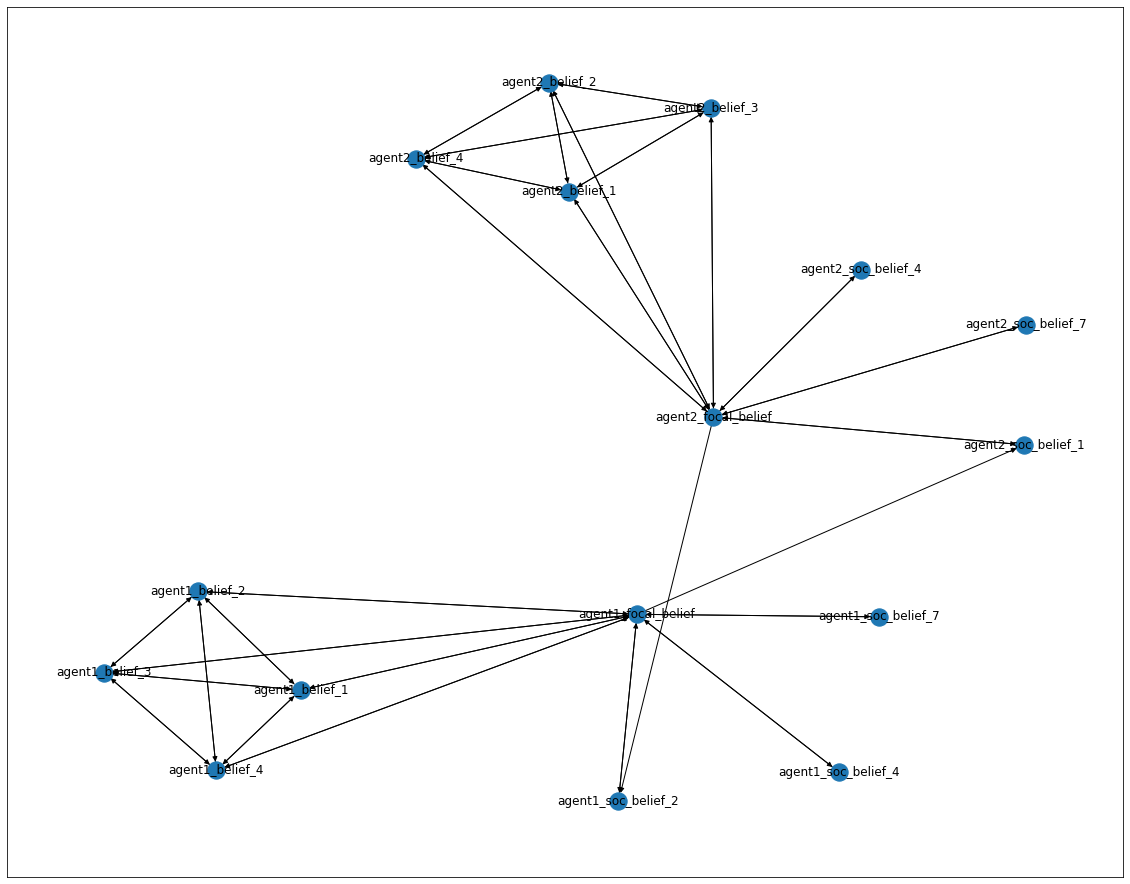

In [288]:
plt.figure(figsize=(20, 16))  # Width and height in inches

# Draw the graph
nx.draw_networkx(fullNet)

# Show plot
plt.show()

In [ ]:
t = test[:10]

new_betas = {}

for i in t.AgentID:
    new_betas[i] = []
    

for index, row in t.iterrows():
    
    soc_beliefs = [belief.split('_')[3]  for belief in row['NodeStates'] if 'soc_belief' in belief]
    
    for i in soc_beliefs:
        print(row.AgentID, i)
        #diff = row.focalNodeStates - 
        diff = row.focalNodeStates - t.loc[t.AgentID == int(i)].focalNodeStates
        #diff = t[int(i)].focalNodeStates
        print(diff)

In [179]:
t.loc[t.AgentID == 1]['focalNodeStates']

1   -0.666667
Name: focalNodeStates, dtype: float64

In [ ]:
soc_beliefs = [belief for belief, value in agent_nodes if 'soc_belief' in belief]

In [143]:
new_betas = {}



In [144]:
t = test[:10]

for i in t.AgentID:
    new_betas[i] = []

In [145]:
new_betas

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [155]:
def scaled_logistic(x, L, k, x0, ymin, ymax):
    # Logistic function
    y = L / (1 + np.exp(-k * (x - x0)))
    # Scale y to be in the range [ymin, ymax]
    # Since x is a single value, scaling directly without min/max functions
    scaled_y = (ymax - ymin) * (y - 0) / (1 - 0) + ymin  # simplified scaling for single x
    # Invert y around the midpoint of ymin and ymax to start and end high
    return ymax + ymin - scaled_y

# Function to get a y value for a given x
def get_y_value(x):
    # Define parameters for the logistic function
    L = 1        # Max value of the unscaled logistic function
    k = 5        # Adjusted steepness of the curve, reduced for a wider transition
    x0 = 1       # Midpoint of the sigmoid, where the lowest point is expected
    ymin = 0.5   # Minimum y value in the desired output
    ymax = 2     # Maximum y value in the desired output

    # Calculate y value using the scaled logistic function
    y = scaled_logistic(x, L, k, x0, ymin, ymax)
    return y

x_value = 2  # You can change this value to test different inputs
y_value = get_y_value(x_value)
print(f"The y value for x = {x_value} is {y_value}")


# Plotting
#plt.figure(figsize=(8, 6))
#plt.plot(x, y, marker='o')  # Line plot with points
#plt.title("Adjusted Scaled and Inverted Logistic Function")
#plt.xlabel("x")
#plt.ylabel("y")
#plt.grid(True)
#plt.show()

The y value for x = 2 is 0.510039276386427


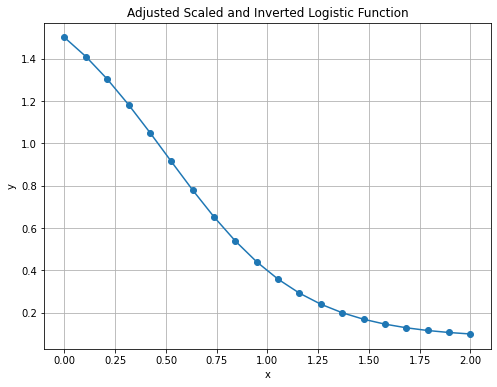

In [193]:
def scaled_logistic(x, L, k, x0, ymin, ymax):
    # Logistic function
    y = L / (1 + np.exp(-k * (x - x0)))
    # Scale y to be in the range [ymin, ymax]
    scaled_y = (y - np.min(y)) / (np.max(y) - np.min(y)) * (ymax - ymin) + ymin
    # Invert y around the midpoint of ymin and ymax to start and end high
    return ymax + ymin - scaled_y

# Create a sequence of x values from 0 to 2
x = np.linspace(0, 2, 20)

# Define parameters for the logistic function
L = 1        # Max value of the unscaled logistic function
k = 3      # Adjusted steepness of the curve, reduced for a wider transition
x0 = 0.5       # Midpoint of the sigmoid, where the lowest point is expected
ymin = 0.1   # Minimum y value in the desired output
ymax = 1.5     # Maximum y value in the desired output

# Calculate y values using the scaled logistic function
y = scaled_logistic(x, L, k, x0, ymin, ymax)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o')  # Line plot with points
plt.title("Adjusted Scaled and Inverted Logistic Function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [1224]:
def create_belief_network(unique_id, n_nodes, connected_agents, weight_int_pers = 0.4, weight_int_soc = 1.0):

    seed = os.getpid() + unique_id
    #np.random.seed(seed)
    rng = default_rng(seed)

    G = nx.DiGraph()

    for i in range(n_nodes):
        G.add_node(f'agent{unique_id}_belief_{i}', value=rng.choice(np.linspace(-1, 1, 7)))

    for c in connected_agents:
        G.add_node(f'agent{unique_id}_soc_belief_{c}', value=rng.choice(np.linspace(-1, 1, 7)))


    focal_node = f'agent{unique_id}_belief_0'

    for i in range(1, n_nodes):
        G.add_edge(focal_node, f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
        G.add_edge(f'agent{unique_id}_belief_{i}', focal_node, weight=weight_int_pers)
        for j in range(1, n_nodes):
            if i != j:
                G.add_edge(f'agent{unique_id}_belief_{j}', f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
                G.add_edge(f'agent{unique_id}_belief_{i}', f'agent{unique_id}_belief_{j}', weight=weight_int_pers) 

    for c in connected_agents:
        G.add_edge(focal_node, f'agent{unique_id}_soc_belief_{c}', weight = weight_int_soc)
        G.add_edge(f'agent{unique_id}_soc_belief_{c}', focal_node, weight = weight_int_soc)


    return G

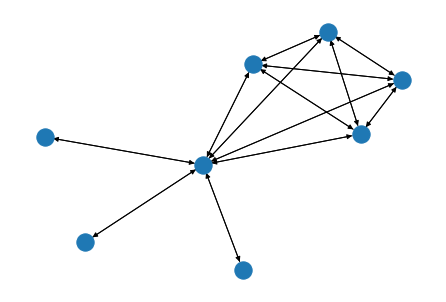

In [1226]:
adj = nx.adjacency_matrix(create_belief_network(1, 5, conn, weight_int_pers = 0.4, weight_int_soc = 1.0)).toarray()

In [195]:
sim = sim[sim.Step > 98].copy()


In [198]:
sim['identifier'] = sim.apply(lambda x: f"{x['betaIntPers']}-{x['betaIntSoc']}-{x['betaExt']}-{x['rep']}", axis=1)

# Step 2: Convert the identifier to a categorical type and assign codes
sim['id'] = sim['identifier'].astype('category').cat.codes
sim = sim.drop(columns = ['identifier'])
sim = sim[['betaIntPers', 'betaIntSoc', 'betaExt', 'AgentID', 'Step', 'id', 'focalNodeStates', 'meanNodeStates', "NodeStates", "rep"]]#, "Test"]]
#sim = sim.rename(columns = {'durchgang' : 'rep'})


In [199]:
#sim = sim[sim.id == 0].copy()

In [1252]:
import networkx as nx
import matplotlib.pyplot as plt

# Existing network data with a new subnetwork added
network_data = list(sim.NodeStates)

netsize = [len(i) for i in network_data]
    

# Create a directed graph
G = nx.DiGraph()

# Add nodes and internal edges
for agent_nodes in network_data:
    focal_node = agent_nodes[0][0]  # The first node is always the focal node
    for node, value in agent_nodes:
        G.add_node(node, value=value)
        beliefs = [belief for belief, value in agent_nodes if 'soc_belief' not in belief]
        for a in beliefs:
            for b in beliefs:
                if a != b:
                    G.add_edge(a, b, weight=0.4)
                    G.add_edge(b, a, weight=0.4)
                    
        if 'belief_0' not in node:
            weight = 1.0 if 'soc_belief' in node else 0.4
            G.add_edge(focal_node, node, weight=weight)
            G.add_edge(node, focal_node, weight=weight)
            
            
#for edge in G.edges(data=True):
#    print(edge)
            
focal_nodes = [node for node in G if ('belief_0' in node) & ('soc_belief' not in node)]
soc_beliefs = [node for node in G if 'soc_belief' in node]



for soc_belief in soc_beliefs:
    agent_index = soc_belief.split('_')[3]  # Extracting agent index from node name like 'agent5_soc_belief_0'
    
    target_focal_node = f'agent{agent_index}_belief_0'
    if target_focal_node in focal_nodes:  # Check if the corresponding focal node exists
        #print(target_focal_node, soc_belief)
        G.add_edge(target_focal_node, soc_belief, weight=1.4)


        
adj = nx.adjacency_matrix(G).toarray()
#for edge in G.edges(data=True):
#    print(edge)

# Plotting the graph
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, edge_color='gray', width=1, font_size=9)
#edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
#plt.show()


In [1253]:
#for edge in G.edges(data=True):
#    print(edge)

In [1254]:
len(adj[adj == .4])

9000

In [1204]:
count = 0
overall = 0
for i, net in enumerate(netsize):
    if len(adj[count][adj[count] == 0.4]) > 2:
        overall = overall +1
    count = count + netsize[i]

In [1201]:
adj[1][adj[1] != 0]

array([0.4])

In [1208]:

adj[:5]

array([[0. , 0.4, 0.4, ..., 0. , 0. , 0. ],
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.4, 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
fullNet = focal_network.copy()
#color for visual "debugging", or observing the network in test runs; very useful when initializing
#node_colors = {} 
#print(f'{soc_beliefs_networks[0][1]} nodes')

for id, net in soc_beliefs_networks:


    fullNet = nx.compose(fullNet, net)
    #fullNet.add_edge(f'agent{id}_belief_0', f'agent{self.unique_id}_soc_belief_{id}', weight = self.weight_ext)
    fullNet.add_edge(f'agent{self.unique_id}_belief_0', f'agent{id}_soc_belief_{self.unique_id}', weight = self.weight_ext)

In [ ]:
    def create_full_connected_network( focal_network, connected_agents):

        #print(f'{self.unique_id}, was trying a fully connected network')
        #print(f'and the network had {len(self.pers_belief_network.nodes())} nodes')

        soc_beliefs_networks = [(connected_agent.unique_id, connected_agent.pers_belief_network) for connected_agent in self.model.schedule.agents if connected_agent.unique_id in connected_agents]

        fullNet = focal_network.copy()
        #color for visual "debugging", or observing the network in test runs; very useful when initializing
        #node_colors = {} 
        #print(f'{soc_beliefs_networks[0][1]} nodes')

        for id, net in soc_beliefs_networks:


            fullNet = nx.compose(fullNet, net)
            #fullNet.add_edge(f'agent{id}_belief_0', f'agent{self.unique_id}_soc_belief_{id}', weight = self.weight_ext)
            fullNet.add_edge(f'agent{self.unique_id}_belief_0', f'agent{id}_soc_belief_{self.unique_id}', weight = self.weight_ext)


            #further coloring of social beliefs and adjacent focal beliefs
            #p_soc_belief = r'agent(\d+)_soc_belief_((?!0)\d+)'
            #p_focal_belief = r'agent(\d+)_soc_belief_0'


            #coloring of all personal beliefs
            #for n in net.nodes():
            #    if re.match(p_focal_belief, n):
            #        node_colors['focal_belief'] = 'red' 
            #    elif re.match(p_soc_belief, n):
            #        node_colors['social_belief'] = 'orange'
            #    else:
            #        node_colors['pers_belief'] = 'lightblue'


        #adj_fullNet = nx.adjacency_matrix(fullNet).toarray()

        self.fullConnNet = fullNet

In [9]:
sim_list = []

for _, group_df in sim.groupby('rep'):
    sim_list.append(group_df)

In [10]:
def create_subsets(data_list):
    subsets = []

    for df in data_list:
        unique_combinations = df[['betaIntPers', 'betaIntSoc', 'betaExt']].drop_duplicates()

        tmp = {}

        for _, row in unique_combinations.iterrows():
            key = (row.betaIntPers, row.betaIntSoc, row.betaExt)
            tmp[key] = df[
                (df['betaIntPers'] == row.betaIntPers) &
                (df['betaIntSoc'] == row.betaIntSoc) &
                (df['betaExt'] == row.betaExt)
            ]

        subsets.append(tmp)
        
    return subsets



In [110]:
subset = create_subsets([sim_a])

In [ ]:
sim_list

In [203]:
def create_results(data):


    #convert extNet to numpy array
    #extNet = np.array(extNet)

    #convert extNet to networkx graph
    #extNetGraph = nx.from_numpy_array(extNet)


    # average results per run: betas
    blockNetBetaIntPers = data.groupby(['rep', 'id'])['betaIntPers'].mean()
    blockNetBetaIntSoc = data.groupby(['rep', 'id'])['betaIntSoc'].mean()
    blockNetBetaExt = data.groupby(['rep', 'id'])['betaExt'].mean()

    # average results per run: focal beliefs
    blockNetFocalMeans = data.groupby(['rep', 'id'])['focalNodeStates'].mean()
    #pre-step to create absolute values of focal beliefs
    data['absFocalNodeStates'] = data['focalNodeStates'].abs()
    blockNetFocalAbsMeans = data.groupby(['rep', 'id'])['absFocalNodeStates'].mean()

    blockNetFocalVar = data.groupby(['rep', 'id'])['focalNodeStates'].var()

    #average results per run: average of all personal beliefs
    blockNetAveMeans = data.groupby(['rep', 'id'])['meanNodeStates'].mean()
    #pre-step to create absolute values of average beliefs
    data['absMeanNodeStates'] = data['meanNodeStates'].abs()
    blockNetAveAbsMeans = data.groupby(['rep', 'id'])['absMeanNodeStates'].mean()

    blockNetAveVar = data.groupby(['rep', 'id'])['meanNodeStates'].var()


    df_05 = pd.DataFrame({
        'focalVar': blockNetFocalVar[blockNetBetaIntPers == 0.5],
        'betaIntSoc': blockNetBetaIntSoc[blockNetBetaIntPers == 0.5],
        'betaExt': blockNetBetaExt[blockNetBetaIntPers == 0.5]
    })
    df_05['betaIntSoc'] = df_05['betaIntSoc'].astype('category')
    df_05['betaExt'] = df_05['betaExt'].astype('category')

    varFocalBetIntPers05 = smf.ols('focalVar ~ betaIntSoc * betaExt', data=df_05).fit()

    df_2 = pd.DataFrame({
    'focalVar': blockNetFocalVar[blockNetBetaIntPers == 2],
    'betaIntSoc': blockNetBetaIntSoc[blockNetBetaIntPers == 2],
    'betaExt': blockNetBetaExt[blockNetBetaIntPers == 2]
    })
    df_2['betaIntSoc'] = df_2['betaIntSoc'].astype('category')
    df_2['betaExt'] = df_2['betaExt'].astype('category')

    varFocalBetIntPers2 = smf.ols('focalVar ~ betaIntSoc * betaExt', data=df_2).fit()

    return data, df_05, df_2 #blockNetBetaIntPers, blockNetFocalMeans, blockNetFocalAbsMeans, blockNetAveMeans, blockNetAveAbsMeans, blockNetAveVar




In [13]:
blockNetBetaIntPers = sim.groupby(['rep', 'id'])['betaIntPers'].mean()
blockNetBetaIntSoc = sim.groupby(['rep', 'id'])['betaIntSoc'].mean()
blockNetBetaExt = sim.groupby(['rep', 'id'])['betaExt'].mean()

blockNetFocalVar = sim.groupby(['rep', 'id'])['focalNodeStates'].var()

In [14]:
blockNetFocalVar[blockNetFocalVar == 0]

Series([], Name: focalNodeStates, dtype: float64)

In [967]:
sim = sim[sim.Step > 98].copy()

In [104]:
df_05 = pd.DataFrame({
    'focalVar': blockNetFocalVar[blockNetBetaIntPers == 0.5],
    'betaIntSoc': blockNetBetaIntSoc[blockNetBetaIntPers == 0.5].astype('category'),
    'betaExt': blockNetBetaExt[blockNetBetaIntPers == 0.5].astype('category')
})

# Fitting the model
model_05 = smf.ols('focalVar ~ betaIntSoc * betaExt', data=df_05).fit()

In [105]:
df_2 = pd.DataFrame({
    'focalVar': blockNetFocalVar[blockNetBetaIntPers == 2],
    'betaIntSoc': blockNetBetaIntSoc[blockNetBetaIntPers == 2].astype('category'),
    'betaExt': blockNetBetaExt[blockNetBetaIntPers == 2].astype('category')
    })

model_2 = smf.ols('focalVar ~ betaIntSoc * betaExt', data=df_2).fit()

In [940]:
from itertools import product

# Getting unique levels of each categorical variable
betaIntSoc_levels = df_2['betaIntSoc'].cat.categories
betaExt_levels = df_2['betaExt'].cat.categories

# Create a DataFrame with all combinations
prediction_df = pd.DataFrame(product(betaIntSoc_levels, betaExt_levels), columns=['betaIntSoc', 'betaExt'])

# Generate predictions for each combination
prediction_df['focalVar_pred'] = model.predict(prediction_df)

In [941]:
prediction_df

,betaIntSoc,betaExt,focalVar_pred
0,0.5,0.5,0.554204
1,0.5,2.0,0.598403
2,2.0,0.5,0.915747
3,2.0,2.0,0.589427


In [47]:
s = 5

In [158]:
sim_a = sim[sim.Step.between(99,100)].copy()

In [159]:
sim_a

,betaIntPers,betaIntSoc,betaExt,AgentID,Step,id,focalNodeStates,meanNodeStates,NodeStates,rep,absFocalNodeStates,absMeanNodeStates
9900,2.0,2.0,2.0,0,99,158,1.0,0.933333,"(agent0_soc_belief_35, agent0_soc_belief_31, a...",8,1.0,0.933333
9901,2.0,2.0,2.0,1,99,158,1.0,0.900000,"(agent1_soc_belief_46, agent1_belief_3, agent1...",8,1.0,0.900000
9902,2.0,2.0,2.0,2,99,158,1.0,0.966667,"(agent2_soc_belief_12, agent2_soc_belief_5, ag...",8,1.0,0.966667
9903,2.0,2.0,2.0,3,99,158,1.0,0.933333,"(agent3_soc_belief_1, agent3_soc_belief_34, ag...",8,1.0,0.933333
9904,2.0,2.0,2.0,4,99,158,1.0,0.933333,"(agent4_soc_belief_35, agent4_belief_8, agent4...",8,1.0,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,2.0,2.0,0.5,95,99,120,-1.0,-0.900000,"(agent95_belief_1, agent95_soc_belief_84, agen...",0,1.0,0.900000
1599996,2.0,2.0,0.5,96,99,120,-1.0,-0.666667,"(agent96_soc_belief_54, agent96_soc_belief_57,...",0,1.0,0.666667
1599997,2.0,2.0,0.5,97,99,120,1.0,0.833333,"(agent97_soc_belief_13, agent97_soc_belief_96,...",0,1.0,0.833333
1599998,2.0,2.0,0.5,98,99,120,1.0,0.933333,"(agent98_soc_belief_94, agent98_belief_6, agen...",0,1.0,0.933333


In [48]:
sim_df = sim_list[s][sim_list[s].Step].copy()

In [201]:
sim_a = sim[sim.Step.between(98,100)].copy()

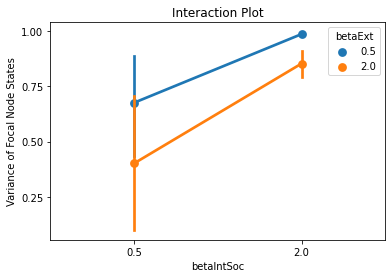

In [204]:
sns.pointplot(x='betaIntSoc', y='focalVar', hue='betaExt', data=create_results(sim_a)[1], errorbar=('ci', 95))
plt.yticks([0.25, 0.5, 0.75, 1])
plt.title('Interaction Plot')
plt.xlabel('betaIntSoc')
plt.ylabel('Variance of Focal Node States')

plt.show()

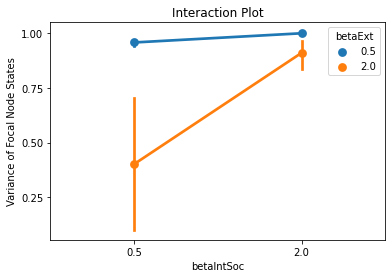

In [205]:
sns.pointplot(x='betaIntSoc', y='focalVar', hue='betaExt', data=create_results(sim_a)[2], errorbar=('ci', 95))
plt.yticks([0.25, 0.5, 0.75, 1])
plt.title('Interaction Plot')
plt.xlabel('betaIntSoc')
plt.ylabel('Variance of Focal Node States')

plt.show()

In [111]:
subset[0][(.5, .5, 2)]['focalNodeStates'].var()

0.585739673372544

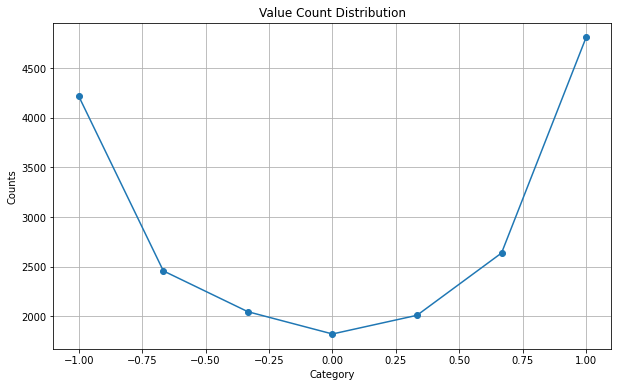

In [112]:
check = subset[0][(.5, .5, 2)]['focalNodeStates'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(np.array(check.index), np.array(check.values), marker='o')  # Line plot
plt.title('Value Count Distribution')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [750]:
df_2 = pd.DataFrame({
    'focalVar': blockNetFocalVar[blockNetBetaIntPers == 2],
    'betaIntSoc': blockNetBetaIntSoc[blockNetBetaIntPers == 2],
    'betaExt': blockNetBetaExt[blockNetBetaIntPers == 2]
    })

In [551]:
sim[(sim.rep == 0) & (sim.id == 140)]#.NodeStates[13500]#.focalNodeStates

,betaIntPers,betaIntSoc,betaExt,AgentID,Step,id,focalNodeStates,meanNodeStates,NodeStates,rep
767200,2.0,2.0,2.0,0,71,140,-1.0,0.100000,"[0.6666666666666665, 0.0, -0.6666666666666667,...",0
767201,2.0,2.0,2.0,1,71,140,-1.0,-0.400000,"[-0.33333333333333337, -0.33333333333333337, -...",0
767202,2.0,2.0,2.0,2,71,140,-1.0,-0.233333,"[-1.0, -1.0, -0.33333333333333337, -0.66666666...",0
767203,2.0,2.0,2.0,3,71,140,-1.0,-0.366667,"[0.0, -1.0, 0.0, -1.0, -0.33333333333333337, -...",0
767204,2.0,2.0,2.0,4,71,140,-1.0,-0.233333,"[1.0, 1.0, -1.0, -1.0, -0.33333333333333337, -...",0
...,...,...,...,...,...,...,...,...,...,...
770095,2.0,2.0,2.0,95,99,140,-1.0,0.100000,"[0.0, 0.33333333333333326, -0.3333333333333333...",0
770096,2.0,2.0,2.0,96,99,140,-1.0,-0.400000,"[-1.0, -1.0, 0.0, -1.0, -0.6666666666666667, -...",0
770097,2.0,2.0,2.0,97,99,140,-1.0,-0.100000,"[1.0, -1.0, 0.33333333333333326, -0.3333333333...",0
770098,2.0,2.0,2.0,98,99,140,-1.0,0.033333,"[0.0, -0.33333333333333337, -0.333333333333333...",0


In [609]:
df_05.focalVar

rep  id
0    0     0.490558
     20    0.591840
     40    0.801679
     60    0.920399
1    1     0.523569
             ...   
18   70    0.091942
19   11    0.527626
     31    0.571529
     51    0.504247
     71    0.001468
Name: focalVar, Length: 80, dtype: float64

In [808]:
smf.ols('focalVar ~ betaIntSoc * betaExt', data=df_05).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               focalVar   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     26.12
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           1.03e-11
Time:                        11:22:23   Log-Likelihood:                 31.393
No. Observations:                  80   AIC:                            -54.79
Df Residuals:                      76   BIC:                            -45.26
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5059      0.037     13.493      0.000       0.431       0.581
betaIntSoc[T.2.0]                    0.4168      0.053      7.861      0.000       0.311       0.522
betaExt[T.2.0]                       0.0739      0.053      1.394      0.167      -0.032       0.180
betaIntSoc[T.2.0]:betaExt[T.2.0]    -0.4495      0.075     -5.995      0.000      -0.599      -0.300
==============================================================================
Omnibus:                        8.634   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               16.531
Skew:                           0.235   Prob(JB):                     0.000257
Kurtosis:                       5.177   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

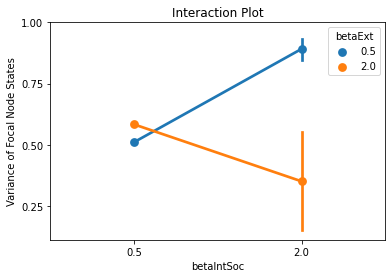

In [114]:
sns.pointplot(x='betaIntSoc', y='focalVar', hue='betaExt', data=create_results(sim_a)[1], errorbar=('ci', 95))
plt.yticks([0.25, 0.5, 0.75, 1])
plt.title('Interaction Plot')
plt.xlabel('betaIntSoc')
plt.ylabel('Variance of Focal Node States')

plt.show()

In [ ]:
check = subsets[8][(.5, 2, .5)]['focalNodeStates'].value_counts().sort_index()   


plt.figure(figsize=(10, 6))
plt.plot(np.array(check.index), np.array(check.values), marker='o')  # Line plot
plt.title('Value Count Distribution')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [492]:
dad_sub = create_subsets([sim])

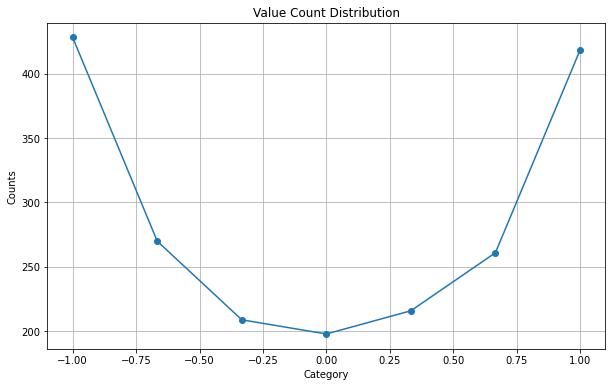

In [495]:
check = dad_sub[0][(2, .5, .5)]['focalNodeStates'].value_counts().sort_index()   


plt.figure(figsize=(10, 6))
plt.plot(np.array(check.index), np.array(check.values), marker='o')  # Line plot
plt.title('Value Count Distribution')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

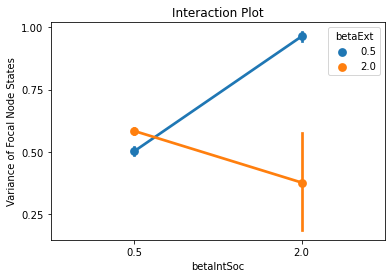

In [720]:
da = sim_list[s][sim_list[s].Step > 40].copy()
sns.pointplot(x='betaIntSoc', y='focalVar', hue='betaExt', data=create_results(sim)[1], errorbar=('ci', 95))
plt.yticks([0.25, 0.5, 0.75, 1])
plt.title('Interaction Plot')
plt.xlabel('betaIntSoc')
plt.ylabel('Variance of Focal Node States')
#plt.savefig('data/betaIntPers2.pdf')
plt.show()

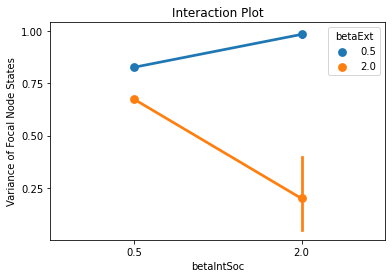

In [115]:
da = sim_list[s][sim_list[s].Step > 40].copy()
sns.pointplot(x='betaIntSoc', y='focalVar', hue='betaExt', data=create_results(sim_a)[2], errorbar=('ci', 95))
plt.yticks([0.25, 0.5, 0.75, 1])
plt.title('Interaction Plot')
plt.xlabel('betaIntSoc')
plt.ylabel('Variance of Focal Node States')
#plt.savefig('data/betaIntPers2.pdf')
plt.show()

In [448]:
sim_list[s]

,betaIntPers,betaIntSoc,betaExt,AgentID,Step,id,focalNodeStates,meanNodeStates,NodeStates,rep
0,0.5,2.0,2.0,0,0,78,1.000000,5.666667e-01,"[1.0, 1.0, 0.33333333333333326, 1.0, -0.333333...",8
1,0.5,2.0,2.0,1,0,78,1.000000,5.666667e-01,"[1.0, 1.0, 0.33333333333333326, 1.0, -0.333333...",8
2,0.5,2.0,2.0,2,0,78,1.000000,5.666667e-01,"[1.0, 1.0, 0.33333333333333326, 1.0, -0.333333...",8
3,0.5,2.0,2.0,3,0,78,1.000000,5.666667e-01,"[1.0, 1.0, 0.33333333333333326, 1.0, -0.333333...",8
4,0.5,2.0,2.0,4,0,78,1.000000,5.666667e-01,"[1.0, 1.0, 0.33333333333333326, 1.0, -0.333333...",8
...,...,...,...,...,...,...,...,...,...,...
394995,2.0,0.5,2.0,95,49,118,-1.000000,-5.000000e-01,"[0.33333333333333326, 1.0, -0.6666666666666667...",8
394996,2.0,0.5,2.0,96,49,118,1.000000,1.333333e-01,"[1.0, 0.0, -0.6666666666666667, -0.66666666666...",8
394997,2.0,0.5,2.0,97,49,118,-1.000000,-3.666667e-01,"[0.0, 0.6666666666666665, -0.33333333333333337...",8
394998,2.0,0.5,2.0,98,49,118,0.666667,-2.666667e-01,"[0.0, -0.33333333333333337, 0.0, -0.6666666666...",8


In [116]:
sim_a.to_csv('data/mesa_fully_conn_top_100.csv')

In [1017]:
subsets[(2, 2, 2)]['focalNodeStates'].value_counts()

TypeError: list indices must be integers or slices, not tuple

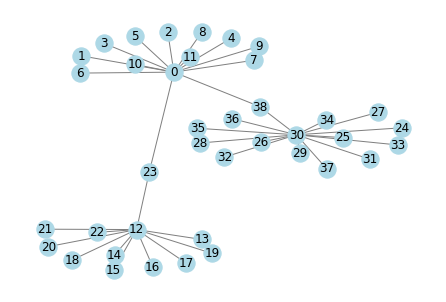

In [276]:
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [13]:
sim_results.reset_index().focalNodeStates.value_counts()

focalNodeStates
-1.000000    64440
 1.000000    19514
-0.666667     8623
 0.666667     8563
-0.333333     6477
 0.333333     6344
 0.000000     6039
Name: count, dtype: int64

In [252]:
adj_mat = []
for i in range(len(sim_results.reset_index().Test[8])):
    adj_mat.append(list(sim_results.reset_index().Test[8][i][0]))

In [59]:
sim = sim_results.reset_index()

In [100]:
sim

,Step,AgentID,betaIntPers,betaIntSoc,betaExt,durchgang,focalNodeStates,meanNodeStates,NodeStates
0,0,0,0.5,0.5,0.5,0,0.666667,-6.661338e-17,"[0.6666666666666665, -1.0, -1.0, -1.0, 0.0, 0...."
1,0,1,0.5,0.5,0.5,0,-0.333333,1.333333e-01,"[-0.33333333333333337, 1.0, -0.333333333333333..."
2,0,2,0.5,0.5,0.5,0,-0.333333,2.000000e-01,"[-0.33333333333333337, 0.0, 0.3333333333333332..."
3,0,3,0.5,0.5,0.5,0,0.000000,-1.000000e-01,"[0.0, -1.0, -0.6666666666666667, 0.0, 0.0, 0.6..."
4,0,4,0.5,0.5,0.5,0,0.666667,-1.333333e-01,"[0.6666666666666665, -0.33333333333333337, -0...."
...,...,...,...,...,...,...,...,...,...
7995,9,95,2.0,0.5,2.0,0,-0.666667,-2.666667e-01,"[0.6666666666666665, -0.6666666666666667, -0.3..."
7996,9,96,2.0,0.5,2.0,0,-0.333333,2.000000e-01,"[-0.33333333333333337, 0.33333333333333326, 1...."
7997,9,97,2.0,0.5,2.0,0,-0.666667,-2.666667e-01,"[1.0, 1.0, -0.33333333333333337, -1.0, -1.0, -..."
7998,9,98,2.0,0.5,2.0,0,-1.000000,-1.333333e-01,"[0.0, 0.0, -0.6666666666666667, 0.0, 1.0, 0.33..."


In [113]:
sim = listed_sim_results[1].reset_index()
sim['identifier'] = sim.apply(lambda x: f"{x['betaIntPers']}-{x['betaIntSoc']}-{x['betaExt']}-{x['Step']}", axis=1)

# Step 2: Convert the identifier to a categorical type and assign codes
sim['id'] = sim['identifier'].astype('category').cat.codes
sim = sim.drop(columns = ['identifier'])
sim = sim[['betaIntPers', 'betaIntSoc', 'betaExt', 'AgentID', 'Step', 'id', 'focalNodeStates', 'meanNodeStates']]#, "NodeStates", "Test"]]

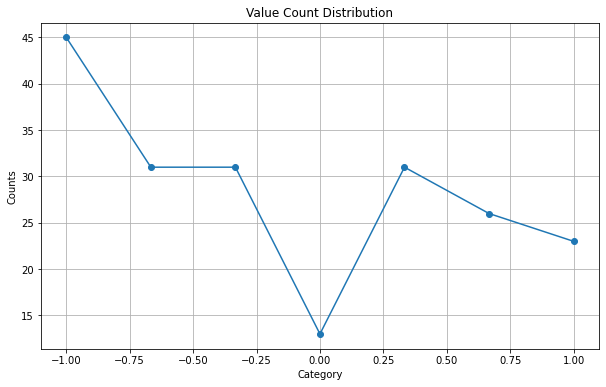

In [114]:
unique_combinations = sim[['betaIntPers', 'betaIntSoc', 'betaExt']].drop_duplicates()

subsets = {}

for _, row in unique_combinations.iterrows():
    key = (row.betaIntPers, row.betaIntSoc, row.betaExt)
    subsets[key] = sim[
        (sim['betaIntPers'] == row.betaIntPers) &
        (sim['betaIntSoc'] == row.betaIntSoc) &
        (sim['betaExt'] == row.betaExt)
    ]

check = subsets[(2, 2, 2)]['focalNodeStates'].value_counts().sort_index()   


plt.figure(figsize=(10, 6))
plt.plot(np.array(check.index), np.array(check.values), marker='o')  # Line plot
plt.title('Value Count Distribution')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [110]:
subsets[(2, 2, 2)]['focalNodeStates'].value_counts()

focalNodeStates
-1.000000    678
 1.000000     81
-0.666667     71
-0.333333     54
 0.666667     51
 0.333333     36
 0.000000     29
Name: count, dtype: int64

In [65]:
sim['identifier'] = sim.apply(lambda x: f"{x['betaIntPers']}-{x['betaIntSoc']}-{x['betaExt']}-{x['Step']}", axis=1)

# Step 2: Convert the identifier to a categorical type and assign codes
sim['id'] = sim['identifier'].astype('category').cat.codes
sim = sim.drop(columns = ['identifier'])
sim = sim[['betaIntPers', 'betaIntSoc', 'betaExt', 'AgentID', 'Step', 'id', 'focalNodeStates', 'meanNodeStates']]#, "NodeStates", "Test"]]

In [ ]:
sim05 = sim[sim['betaIntPers'] == 0.5]
sim2 = sim[sim['betaIntPers'] == 2]


In [46]:
unique_combinations = sim[['betaIntPers', 'betaIntSoc', 'betaExt']].drop_duplicates()

subsets = {}

for _, row in unique_combinations.iterrows():
    key = (row.betaIntPers, row.betaIntSoc, row.betaExt)
    subsets[key] = sim[
        (sim['betaIntPers'] == row.betaIntPers) &
        (sim['betaIntSoc'] == row.betaIntSoc) &
        (sim['betaExt'] == row.betaExt)
    ]

subsets[(0.5, 2.0, 2.0)]

,betaIntPers,betaIntSoc,betaExt,AgentID,Step,id,focalNodeStates,meanNodeStates,NodeStates,Test
20000,0.5,2.0,2.0,0,0,150,-1.000000,-0.266667,"[-1.0, -1.0, 0.0, 0.6666666666666665, -1.0, -0...",[]
20001,0.5,2.0,2.0,1,0,150,0.666667,-0.066667,"[0.6666666666666665, -0.6666666666666667, -0.6...",[]
20002,0.5,2.0,2.0,2,0,150,0.000000,0.300000,"[0.0, 1.0, 0.6666666666666665, 0.0, 0.33333333...",[]
20003,0.5,2.0,2.0,3,0,150,0.000000,0.066667,"[0.0, -1.0, 1.0, -0.33333333333333337, -0.6666...",[]
20004,0.5,2.0,2.0,4,0,150,0.666667,-0.033333,"[0.6666666666666665, -0.6666666666666667, 0.33...",[]
...,...,...,...,...,...,...,...,...,...,...
24995,0.5,2.0,2.0,95,49,194,0.000000,-0.066667,"[0.6666666666666665, 0.0, -0.6666666666666667,...",[]
24996,0.5,2.0,2.0,96,49,194,-0.333333,-0.233333,"[-0.33333333333333337, 0.0, -0.333333333333333...",[]
24997,0.5,2.0,2.0,97,49,194,-0.666667,-0.266667,"[-1.0, 0.33333333333333326, 0.6666666666666665...",[]
24998,0.5,2.0,2.0,98,49,194,-0.333333,-0.300000,"[0.6666666666666665, 0.33333333333333326, 0.0,...",[]


In [217]:
a2 = sim[sim["AgentID"] == 2]

In [ ]:
a2.Test[2]

In [221]:
a2.focalNodeStates.value_counts()

focalNodeStates
 0.666667    10
-0.333333     8
 1.000000     6
 0.000000     5
-1.000000     4
-0.666667     4
 0.333333     3
Name: count, dtype: int64

In [167]:
values = []
a = a2.Test[2][0][1]
for i in range(10000):#len(a2.Test[2])):
    
    probUnstPerValue = []
    for v in np.linspace(-1, 1, 7):
        probUnstPerValue.append(1/(1+ np.exp((-np.sum(a2.Test[2][8][0] * v * a2.Test[2][8][3]) + np.sum(a2.Test[2][8][0] * a * a2.Test[2][8][3])))))
    probPerValue = [k / sum(probUnstPerValue) for k in probUnstPerValue]
    
    a = np.random.choice(np.linspace(-1, 1, 7), 1,  p=probPerValue)[0]
    values.append(a)

In [ ]:
values

In [169]:
pd.Series(values).value_counts()

 1.000000    2033
 0.666667    1815
 0.333333    1615
 0.000000    1386
-0.333333    1235
-0.666667    1040
-1.000000     876
Name: count, dtype: int64

In [224]:
probUnstPerValue

[0.5,
 0.5525826312265957,
 0.6040148856494987,
 0.6532449007182832,
 0.6994004409005217,
 0.7418402904888364,
 0.7801716022593173]

In [225]:
probPerValue = [k / sum(probUnstPerValue) for k in probUnstPerValue]

In [226]:
probPerValue

[0.1103447118842382,
 0.12194914246986588,
 0.13329969706157002,
 0.1441642407192135,
 0.15435028028575445,
 0.16371630623622044,
 0.17217562134313766]

In [252]:
np.random.choice(np.linspace(-1, 1, 7), 1,  p=probPerValue)[0]

-0.6666666666666667

In [242]:
observe = [a2.Test[2][i][1] for i in range(len(a2.Test[2]))]
    

In [341]:
sim

,betaIntPers,betaIntSoc,betaExt,AgentID,Step,id,focalNodeStates,meanNodeStates
0,2.0,2.0,0.5,0,0,600,1.000000,-0.300000
1,2.0,2.0,0.5,1,0,600,0.333333,-0.100000
2,2.0,2.0,0.5,2,0,600,-0.333333,0.533333
3,2.0,2.0,0.5,3,0,600,-0.666667,-0.400000
4,2.0,2.0,0.5,4,0,600,-0.333333,0.400000
...,...,...,...,...,...,...,...,...
79995,2.0,0.5,0.5,95,99,499,1.000000,0.500000
79996,2.0,0.5,0.5,96,99,499,0.000000,0.033333
79997,2.0,0.5,0.5,97,99,499,0.000000,-0.100000
79998,2.0,0.5,0.5,98,99,499,0.000000,-0.100000


In [66]:
sim.to_csv('data/mesa_polarized_100steps.csv')